# ADL252 -  Deep Learning Practical Session 4 - Regression


In [2]:
from __future__ import print_function, division

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import numpy as np
import matplotlib.pyplot as plt
import time

from tqdm import tqdm



# Regression problem #1 - Signal Regression

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Data
def generate_data(n_points=100):
    x = np.linspace(-2, 2, n_points)
    y = np.sin(1.5 * x) + np.sin(3.5 * x) + np.random.normal(scale=0.2, size=n_points)
    return x, y

# Generate train and test data
X_train, y_train = generate_data(50)
X_test, y_test = generate_data(100)
print("X_train.shape:", X_train.shape)

X_train.shape: (50,)


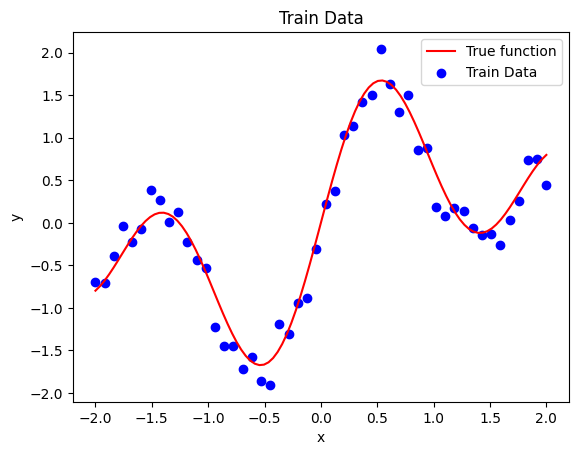

In [4]:
# Plot the train data
x = np.linspace(-2, 2, 100)
fx = np.sin(1.5 * x) + np.sin(3.5 * x)

plt.plot(x, fx, c='r', label="True function")
plt.scatter(X_train, y_train, color='blue', label='Train Data')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Train Data')
plt.legend()
plt.show()

In [5]:
def train_regression_model(model, X, y, optimizer, criterion):
  # train
  model.train()
  loss_list = []
  for epoch in tqdm(range(2000)):
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    # y_true (N,), y_pred (N,1)
    y_pred = model(X).squeeze()
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
  return loss_list

In [6]:
# Prepare data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor, y_train_tensor = torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device).float()
X_test_tensor, y_test_tensor = torch.Tensor(X_test).to(device), torch.Tensor(y_test).to(device).float()
# reshape
X_train_tensor = X_train_tensor.view(-1, 1)
X_test_tensor = X_test_tensor.view(-1, 1)

## Model

In [7]:
# Setup

hidden_size = 1024
output_size = 1
input_size = 1
lr = 0.01
# What loss function should we use?
criterion = nn.MSELoss()

linear_model = nn.Sequential(nn.Linear(input_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, output_size))

optimizer = optim.SGD(linear_model.parameters(), lr=lr)

mlp_model = linear_model.to(device)

In [8]:
mlp_model

Sequential(
  (0): Linear(in_features=1, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=1, bias=True)
)

In [9]:
loss_list = train_regression_model(linear_model, X_train_tensor, y_train_tensor, optimizer, criterion)

100%|██████████| 2000/2000 [00:03<00:00, 650.82it/s]


## Evaluate Model

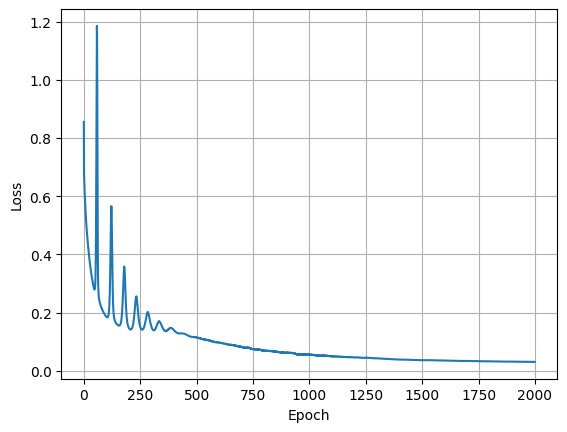

In [10]:
plt.plot(loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.ylim(0,1)
plt.grid()
plt.show()

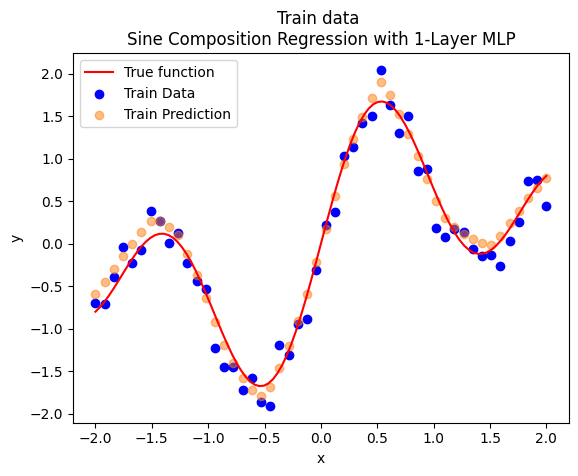

In [11]:
# Predict on train and test data
mlp_model.eval()
with torch.no_grad():
    y_train_pred = mlp_model(X_train_tensor).cpu().numpy()
    y_test_pred = mlp_model(X_test_tensor).cpu().numpy()

# Plot the results
plt.plot(x, fx, c='r', label="True function")
plt.scatter(X_train, y_train, color='blue', label='Train Data')
plt.scatter(X_train, y_train_pred, color='tab:orange', label='Train Prediction', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Train data \nSine Composition Regression with 1-Layer MLP')
plt.legend()
plt.show()

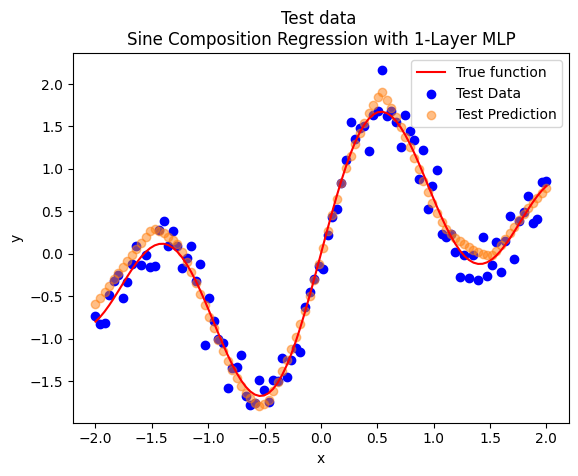

In [12]:
# Plot the results
plt.plot(x, fx, c='r', label="True function")
plt.scatter(X_test, y_test, color='blue', label='Test Data')
plt.scatter(X_test, y_test_pred, color='tab:orange', label='Test Prediction', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Test data \nSine Composition Regression with 1-Layer MLP')
plt.legend()
plt.show()

# Regression Problem #2 - Circles value regression
## Data

In [13]:
def generate_concentric_circles_data(radii=[1, 2, 3, 4], points_per_circle=100, random_state=42):
    np.random.seed(random_state)
    X, y = [], []

    for i, radius in enumerate(radii):
        angles = np.linspace(0, 2 * np.pi, points_per_circle, endpoint=False)
        circle_x = radius * np.cos(angles) + np.random.normal(0, 0.2, points_per_circle)
        circle_y = radius * np.sin(angles) + np.random.normal(0, 0.2, points_per_circle)
        # (N, 2)
        data = np.vstack((circle_x, circle_y)).T

        #(N, ). sqrt(sum((x-y)**2)):
        labels = np.linalg.norm(data - np.zeros_like(data), axis=1)
        X.append(data)
        y.append(labels)

    # (N, 2), (N, )
    X = np.vstack(X)
    y = np.hstack(y)
    return X, y

In [14]:
def plot_data(X, y, title=""):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.colorbar(cmap='reds')
    plt.show()

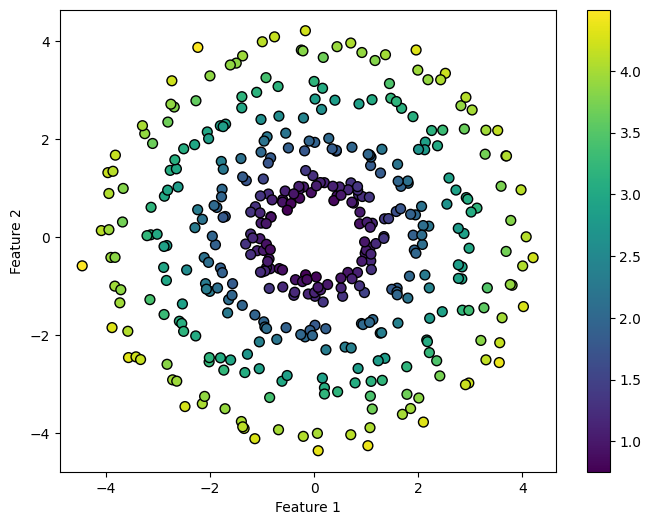

In [15]:
# Generate the data
X_train2, y_train2 = generate_concentric_circles_data(random_state=0)
X_test2, y_test2 = generate_concentric_circles_data(random_state=1)

# Plot the data
plot_data(X_train2, y_train2)


# Model

In [16]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hidden_size =16
output_size = 1
input_size = 2
lr = 0.1
# What loss function should we use?
criterion = nn.MSELoss()

mlp_model2 = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, output_size)

)

mlp_optimizer2  = optim.SGD(mlp_model2.parameters(), lr=lr)


# to device
mlp_model2 = mlp_model2.to(device)

## Train

In [17]:
mlp_model2

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)

In [18]:
# Prepare data

X_train_tensor2, y_train_tensor2 = torch.Tensor(X_train2).to(device), torch.Tensor(y_train2).to(device).float()
X_test_tensor2, y_test_tensor2 = torch.Tensor(X_test2).to(device), torch.Tensor(y_test2).to(device).float()


In [19]:
loss_list2 = train_regression_model(mlp_model2, X_train_tensor2, y_train_tensor2, mlp_optimizer2, criterion)

100%|██████████| 2000/2000 [00:02<00:00, 902.37it/s]


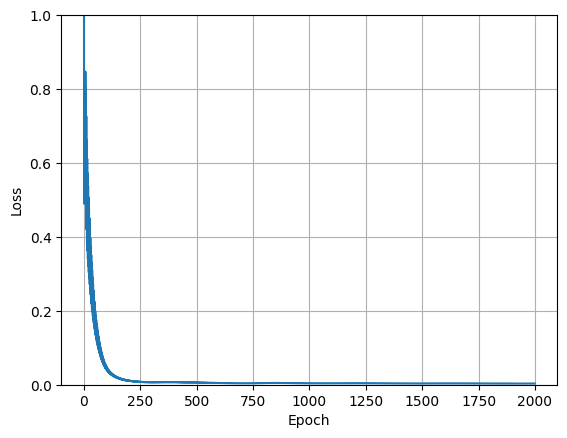

In [20]:
plt.plot(loss_list2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0,1)
plt.grid()
plt.show()

# Evaluate

In [21]:
with torch.no_grad():
  y_test_pred2 = mlp_model2(X_test_tensor2.to(device))
  y_test_pred2 = y_test_pred2.cpu().numpy()


In [22]:
y_test2.shape, y_test_pred2.shape

((400,), (400, 1))

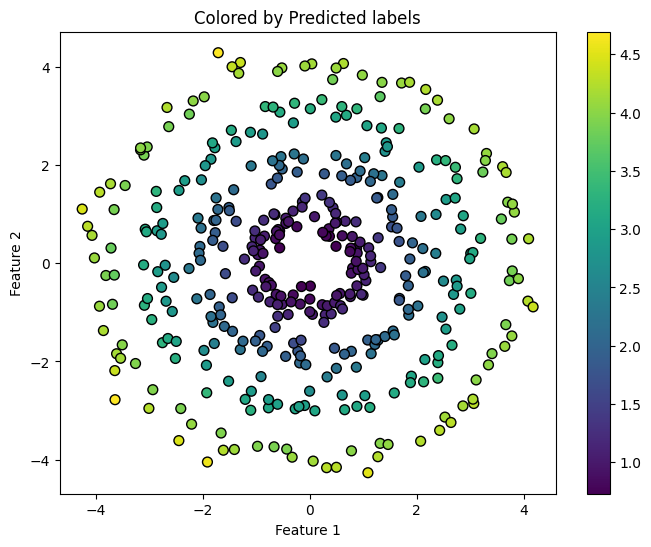

In [24]:
y_diff = y_test2 - y_test_pred2.squeeze()
#plot_data(X_test2, y_test2, title="Colored by True labels")
plot_data(X_test2, y_test_pred2, title="Colored by Predicted labels")
#plot_data(X_test2, y_diff, title="Colored by Residuals")

